In [19]:
import typing

import polyflexmd.data_analysis.plot.msd as plot_msd
import polyflexmd.experiment_runner.config as config
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.transform.transform as transform
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns

%load_ext autoreload
%autoreload 2

sns.set_style("darkgrid")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick label
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
PATH_REL_ETE = "data/processed/ete.csv"

In [21]:
def aggregate_time_mean_ete(df_ete: pd.DataFrame, time_bucket_size: int, var_index: list[str]) -> pd.DataFrame:
    df_ete_agg =  df_ete.groupby(var_index+["molecule-ID", df_ete.index.get_level_values("t") // time_bucket_size], as_index=True).agg(np.mean)
    df_ete_agg.reset_index(level="t", drop=False, inplace=True)
    df_ete_agg["t"] = df_ete_agg["t"]*time_bucket_size
    df_ete_agg.set_index("t", append=True, inplace=True)
    return df_ete_agg


def get_dataset_ete_equi(
        conf: config.ExperimentConfig,
        experiment_path: pathlib.Path,
        var_index: list[str]
) -> pd.DataFrame:
    df = pd.read_csv(experiment_path / PATH_REL_ETE, index_col=var_index + ["molecule-ID", "t"])
    return df.loc[df.index.get_level_values("t") >= conf.simulation_config.variables["n_relax_steps"]]

## EEA1+Rab5

In [22]:
PATH_EXPERIMENT_CONNECTED = pathlib.Path("/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-vary-l_K-vary-d_end/15-EEA1_short+Rab5_10x/b7015f55")
PATH_EXPERIMENT_CONNECTED

PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-vary-l_K-vary-d_end/15-EEA1_short+Rab5_10x/b7015f55')

In [23]:
CONF_CONNECTED = config.read_experiment_config(next(PATH_EXPERIMENT_CONNECTED.glob("*.toml")))
CONF_CONNECTED

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='144:00:00', partition='romeo', nodes=1, tasks_per_node=125, ntasks=125, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/beegfs/ws/0/s4610340-polyflexmd/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K-vary-d_end.lammps'), experiments_path=PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results'), n_partitions=1, n_tasks_per_partition=125, variables={'kappa_start': 190.2, 'kappa_delta': 0.0, 'kappa_n_values': 1, 'm_end': 1.5, 'd_end_start': 15, 'd_end_delta': 0.0, 'd_end_n_values': 1, 'n_relax_steps': 20000000, 'n_equilibrium_steps_1': 2000000, 'dump_frequency_1': 100, 'n_equilibrium_steps_2': 28000000, 'dump_frequency_2': 10000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpo

### Get data

#### ETE

In [24]:
df_ete_conn = aggregate_time_mean_ete(get_dataset_ete_equi(CONF_CONNECTED, PATH_EXPERIMENT_CONNECTED, var_index=["kappa", "d_end"]), time_bucket_size=1, var_index=["kappa", "d_end"])
df_ete_conn

R_x        R_y        R_z          R
kappa d_end molecule-ID t                                                   
190.2 15.0  1           20000000 -33.747601  18.192801 -45.704102  59.655205
                        20000100 -33.828400  17.974600 -45.742100  59.663947
                        20000200 -33.802299  17.854900 -45.730000  59.603907
                        20000300 -33.849800  17.888500 -45.611401  59.550040
                        20000400 -33.844700  17.890800 -45.696201  59.612811
...                                     ...        ...        ...        ...
            1000        49960000 -21.885401  54.804600  -1.491340  59.031678
                        49970000 -21.317801  54.397400  -0.458526  58.427185
                        49980000 -23.540001  53.861401  -1.014180  58.789546
                        49990000 -24.158300  53.656898  -1.617420  58.866818
                        50000000 -26.087900  52.334801   0.103927  58.476668

[22801000 rows x 4 columns]

<Axes: xlabel='t', ylabel='R'>

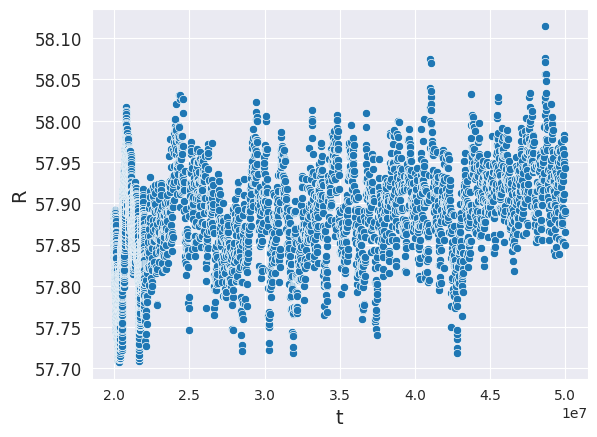

In [25]:
sns.scatterplot(
    df_ete_conn.groupby(["kappa", "d_end", "t"])["R"].mean().reset_index(),
    x="t",
    y="R",
)

#### Main axis

In [26]:
df_main_ax_conn = pd.read_csv(
    PATH_EXPERIMENT_CONNECTED / "data" / "processed" / "main_axis.csv"
).groupby("molecule-ID", as_index=True).nth(1)
df_main_ax_conn

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,-0.159927,-0.017451,-0.956566,0,0,0
3,2,1,-0.483684,-0.375608,0.752242,0,0,0
5,3,1,-0.036845,0.008633,0.969262,0,0,0
7,4,1,-0.050426,0.667705,-0.701803,0,0,0
9,5,1,-0.117898,0.182993,0.945258,0,0,0
...,...,...,...,...,...,...,...,...
1991,996,1,0.815395,0.492707,-0.182400,0,0,0
1993,997,1,0.373337,-0.191865,0.874475,0,0,0
1995,998,1,0.340244,-0.276341,-0.865315,0,0,0
1997,999,1,-0.260711,0.095793,0.929383,0,0,0


#### Kuhn length $l_K$

In [27]:
l_K_estimate_conn: pd.Series = pd.read_csv(PATH_EXPERIMENT_CONNECTED / "data" / "processed" / "l_K-estimate.csv").iloc[0]
l_K_estimate_conn

kappa    190.200000
d_end     15.000000
l_K      179.009757
d_l_K      6.327430
Name: 0, dtype: float64

#### Bond length $l_b$

In [28]:
l_b = CONF_CONNECTED.initial_system_config.system_config.bond_length
l_b

0.97

#### Contour length L

In [29]:
L_contour = l_b*(CONF_CONNECTED.initial_system_config.system_config.n_monomers-1)
L_contour

61.11

#### End monomer mass

In [30]:
m_end_conn = CONF_CONNECTED.simulation_config.variables["m_end"]
m_end_conn

1.5

#### Friction coefficient of end monomer $\zeta_e$

In [31]:
zeta_end_conn = l_K_estimate_conn["d_end"] / m_end_conn
zeta_end_conn

10.0

#### MSD

In [32]:
def with_transformed_time_msd_df(df_msd: pd.DataFrame):
    df_msd["t/LJ"] = df_msd.index.get_level_values("t").map(lambda t: t*0.0025)
    df_msd["t/LJ"] = df_msd["t/LJ"] - df_msd["t/LJ"].min()

In [33]:
df_msd_conn = transform.calculate_ens_avg_df_ete_change_kappas_dend(df_ete_conn)
with_transformed_time_msd_df(df_msd_conn)
df_msd_conn

,dR^2,kappa,d_end,t/LJ
t,,,,
20000000,0.000000,190.2,15.0,0.00
20000100,0.044474,190.2,15.0,0.25
20000200,0.106921,190.2,15.0,0.50
20000300,0.168443,190.2,15.0,0.75
20000400,0.229166,190.2,15.0,1.00
...,...,...,...,...
49960000,1310.357253,190.2,15.0,74900.00
49970000,1313.188240,190.2,15.0,74925.00
49980000,1315.608592,190.2,15.0,74950.00


#### MSD by dimension in main-axis coordinate system

In [34]:
df_ete_conn_main_ax_frame = transform.change_basis_df_ete(df_ete_conn, df_main_ax_conn)
df_ete_conn_main_ax_frame

R_x        R_y        R_z          R
kappa d_end molecule-ID t                                                   
190.2 15.0  1           20000000 -25.806331  19.023413  50.307917  59.655205
                        20000100 -25.879104  18.805941  50.362636  59.663947
                        20000200 -25.854996  18.686041  50.348553  59.603907
                        20000300 -25.921498  18.717472  50.238824  59.550040
                        20000400 -25.902496  18.721319  50.321568  59.612811
...                                     ...        ...        ...        ...
            1000        49960000  -0.899289  -0.316319  59.023980  59.031678
                        49970000  -0.522043   0.707530  58.420569  58.427185
                        49980000  -2.785011   0.140515  58.723374  58.789546
                        49990000  -3.430961  -0.466970  58.764894  58.866818
                        50000000  -5.718183   1.225644  58.183510  58.476668

[22801000 rows x 4 columns]

In [35]:
df_msd_conn_main_ax_frame = transform.calculate_msd_by_dimension_df(df_ete_conn_main_ax_frame, ["kappa", "d_end"])
with_transformed_time_msd_df(df_msd_conn_main_ax_frame)
df_msd_conn_main_ax_frame

,dR_x^2,dR_y^2,dR_z^2,dR^2,kappa,d_end,t/LJ
t,,,,,,,
20000000,0.000000,0.000000,0.000000,0.000000,190.2,15.0,0.00
20000100,0.015559,0.015495,0.013420,0.044474,190.2,15.0,0.25
20000200,0.039650,0.037642,0.029628,0.106921,190.2,15.0,0.50
20000300,0.061717,0.060423,0.046303,0.168443,190.2,15.0,0.75
20000400,0.082139,0.086282,0.060745,0.229166,190.2,15.0,1.00
...,...,...,...,...,...,...,...
49960000,639.660687,575.986349,94.710218,1310.357253,190.2,15.0,74900.00
49970000,640.217680,578.000607,94.969953,1313.188240,190.2,15.0,74925.00
49980000,642.655963,577.163772,95.788857,1315.608592,190.2,15.0,74950.00


### Explore

#### Plot MSD

<Axes: title={'center': 'MSD for $l_K/L=2.93$, $\\zeta_e=10.0$, $\\zeta=1.0$, $L=61.11$'}, xlabel='t/LJ', ylabel='$ \\sqrt {{\\langle (\\Delta R(t))^2 \\rangle}} / L$'>

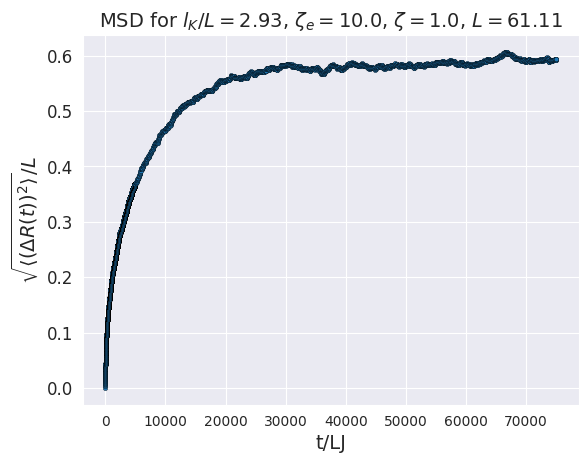

In [44]:
plot_msd.plot_MSD(df_msd_conn_main_ax_frame, log_scale=False, l_K=l_K_estimate_conn["l_K"], L_contour=L_contour, zeta=1.0, zeta_e=zeta_end_conn)

<Axes: title={'center': 'MSD on log-log scale for $l_K/L=2.93$, $\\zeta_e=10.0$, $\\zeta=1.0$, $L=61.11$'}, xlabel='t/LJ', ylabel='$ \\sqrt {{\\langle (\\Delta R(t))^2 \\rangle}} / L$'>

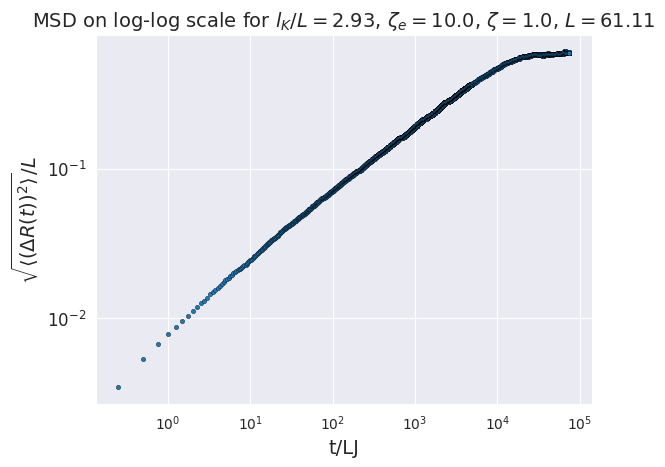

In [45]:
plot_msd.plot_MSD(df_msd_conn, log_scale=True, l_K=l_K_estimate_conn["l_K"], L_contour=L_contour, zeta=1.0, zeta_e=zeta_end_conn)

#### Plot MSD dimensions

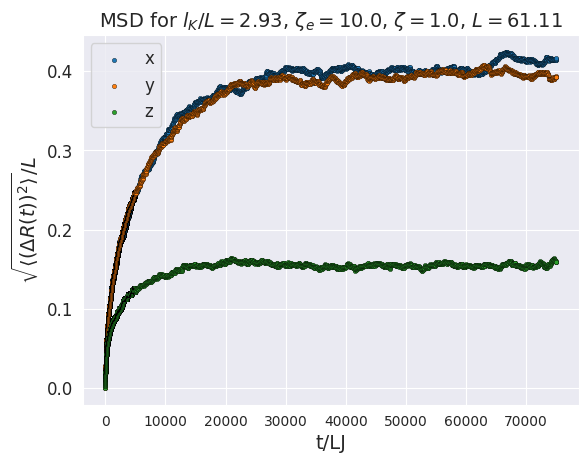

In [46]:
dims = ["x", "y", "z"]
for dim in dims:
    plot_msd.plot_MSD(
        df_msd_conn_main_ax_frame,
        log_scale=False,
        label=dim,
        col=f"dR_{dim}^2",
        l_K=l_K_estimate_conn["l_K"],
        L_contour=L_contour,
        zeta=1.0,
        zeta_e=zeta_end_conn
    )

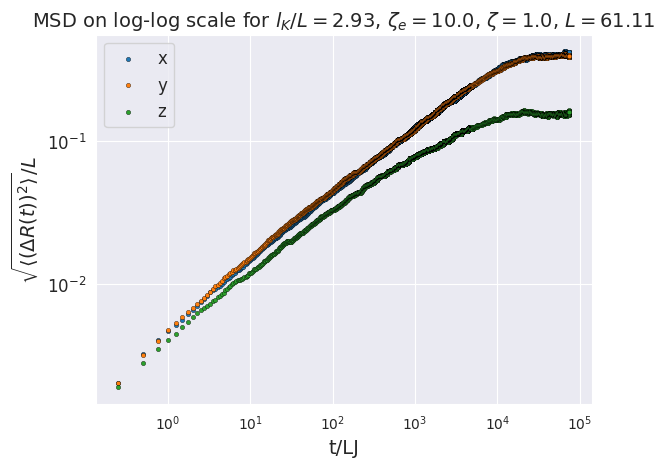

In [47]:
dims = ["x", "y", "z"]
for dim in dims:
    plot_msd.plot_MSD(
        df_msd_conn_main_ax_frame,
        log_scale=True,
        label=dim,
        col=f"dR_{dim}^2",
        l_K=l_K_estimate_conn["l_K"],
        L_contour=L_contour,
        zeta=1.0,
        zeta_e=zeta_end_conn
    )

## Bare EEA1

In [48]:
PATH_EXPERIMENT_BARE = pathlib.Path("/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-vary-l_K/14-EEA1_short/b7015f55")
PATH_EXPERIMENT_BARE

PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-vary-l_K/14-EEA1_short/b7015f55')

In [49]:
CONF_BARE = config.read_experiment_config(next(PATH_EXPERIMENT_BARE.glob("*.toml")))
CONF_BARE

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='144:00:00', partition='romeo', nodes=1, tasks_per_node=125, ntasks=125, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/beegfs/ws/0/s4610340-polyflexmd/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K.lammps'), experiments_path=PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results'), n_partitions=1, n_tasks_per_partition=125, variables={'kappa_start': 190.2, 'kappa_delta': 0.0, 'kappa_n_values': 1, 'n_relax_steps': 35000000, 'n_equilibrium_steps_1': 2000000, 'dump_frequency_1': 100, 'n_equilibrium_steps_2': 38000000, 'dump_frequency_2': 10000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_node=1, ntasks=1, cpus_

### Get data

#### ETE

In [50]:
df_ete_bare = aggregate_time_mean_ete(
    get_dataset_ete_equi(CONF_BARE, PATH_EXPERIMENT_BARE, var_index=["kappa"]),
    time_bucket_size=1,
    var_index=["kappa"]
)
df_ete_bare

R_x        R_y        R_z          R
kappa molecule-ID t                                                   
190.2 1           35000000 -17.492100  23.400400  48.040298  56.226529
                  35000100 -17.563801  23.353300  48.140400  56.314846
                  35000200 -17.792400  23.344101  48.254200  56.479947
                  35000300 -17.990900  23.195601  48.242298  56.471477
                  35000400 -18.096201  23.316999  48.132801  56.461682
...                               ...        ...        ...        ...
      1000        74960000   2.917540  14.273500 -53.867401  55.802704
                  74970000   7.322770  17.401699 -51.915298  55.241654
                  74980000   4.536860  15.947400 -53.958199  56.448117
                  74990000   5.750030  13.618100 -54.281502  56.258305
                  75000000   9.714720  16.445499 -52.785999  56.135479

[23801000 rows x 4 columns]

<Axes: xlabel='t', ylabel='R'>

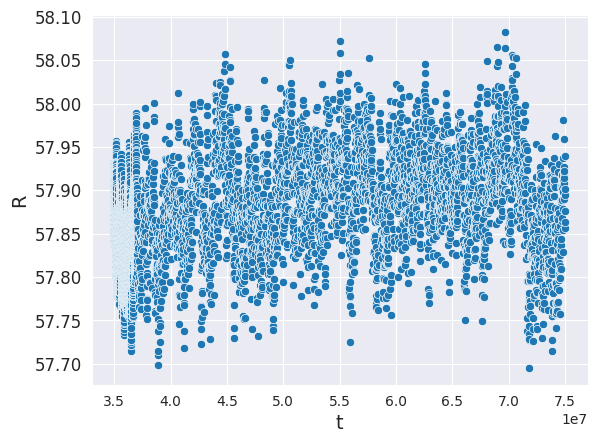

In [51]:
sns.scatterplot(
    df_ete_bare.groupby(["kappa", "t"])["R"].mean().reset_index(),
    x="t",
    y="R",
)

#### Other

In [52]:
df_main_ax_bare = pd.read_csv(
    PATH_EXPERIMENT_BARE / "data" / "processed" / "main_axis.csv"
).groupby("molecule-ID", as_index=True).nth(1)
df_main_ax_bare

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,-0.336178,0.186169,0.890632,0,0,0
3,2,1,-0.272215,-0.119898,0.923268,0,0,0
5,3,1,-0.517323,-0.532615,-0.624178,0,0,0
7,4,1,0.302546,-0.396453,0.831980,0,0,0
9,5,1,-0.592061,0.192979,0.743722,0,0,0
...,...,...,...,...,...,...,...,...
1991,996,1,-0.229209,-0.331939,0.882145,0,0,0
1993,997,1,-0.397862,0.883124,0.051938,0,0,0
1995,998,1,-0.620473,-0.566230,0.485074,0,0,0
1997,999,1,0.157985,0.168384,-0.942119,0,0,0


In [53]:
l_b = CONF_BARE.initial_system_config.system_config.bond_length
l_b

0.97

In [54]:
kappa = CONF_BARE.simulation_config.variables["kappa_start"]
kappa

190.2

In [55]:
l_K_bare = kremer_grest.bare_kuhn_length(kappa, l_b=l_b)
l_K_bare

368.018

#### MSD

In [56]:
df_msd_bare = transform.calculate_ens_avg_df_ete_change_kappas(df_ete_bare)
with_transformed_time_msd_df(df_msd_bare)
df_msd_bare

,dR^2,kappa,t/LJ
t,,,
35000000,0.000000,190.2,0.00
35000100,0.094404,190.2,0.25
35000200,0.265925,190.2,0.50
35000300,0.482227,190.2,0.75
35000400,0.728732,190.2,1.00
...,...,...,...
74960000,1270.524082,190.2,99900.00
74970000,1265.159429,190.2,99925.00
74980000,1264.520954,190.2,99950.00


#### MSD by dimension in main-axis c-system

In [57]:
df_ete_bare_main_ax_frame = transform.change_basis_df_ete(df_ete_bare, df_main_ax_bare)
df_ete_bare_main_ax_frame

R_x        R_y        R_z          R
kappa molecule-ID t                                                   
190.2 1           35000000   1.548742 -13.075889  54.663014  56.226529
                  35000100   1.512104 -13.009304  54.770735  56.314846
                  35000200   1.335626 -12.977015  54.952685  56.479947
                  35000300   1.134861 -12.834092  54.982051  56.471477
                  35000400   1.007549 -12.975326  54.941307  56.461682
...                               ...        ...        ...        ...
      1000        74960000  20.213522  31.893679  41.087085  55.802704
                  74970000  23.167664  34.161928  36.713245  55.241654
                  74980000  21.521575  33.497074  40.014469  56.448117
                  74990000  23.064938  31.420203  40.568170  56.258305
                  75000000  25.816191  33.562626  36.854666  56.135479

[23801000 rows x 4 columns]

In [58]:
df_msd_bare_main_ax_frame = transform.calculate_msd_by_dimension_df(df_ete_bare_main_ax_frame, ["kappa"])
with_transformed_time_msd_df(df_msd_bare_main_ax_frame)
df_msd_bare_main_ax_frame

,dR_x^2,dR_y^2,dR_z^2,dR^2,kappa,t/LJ
t,,,,,,
35000000,0.000000,0.000000,0.000000,0.000000,190.2,0.00
35000100,0.033190,0.036728,0.024486,0.094404,190.2,0.25
35000200,0.098827,0.102709,0.064389,0.265925,190.2,0.50
35000300,0.180132,0.186046,0.116049,0.482227,190.2,0.75
35000400,0.277797,0.284607,0.166328,0.728732,190.2,1.00
...,...,...,...,...,...,...
74960000,581.399554,597.226181,91.898347,1270.524082,190.2,99900.00
74970000,578.008304,595.946545,91.204580,1265.159429,190.2,99925.00
74980000,576.048289,596.225666,92.246999,1264.520954,190.2,99950.00


### Explore

#### Plot MSD

<Axes: title={'center': 'MSD for $l_K/L=6.02$, $\\zeta_e = \\zeta= 1.00$, $L=61.11$'}, xlabel='t/LJ', ylabel='$ \\sqrt {{\\langle (\\Delta R(t))^2 \\rangle}} / L$'>

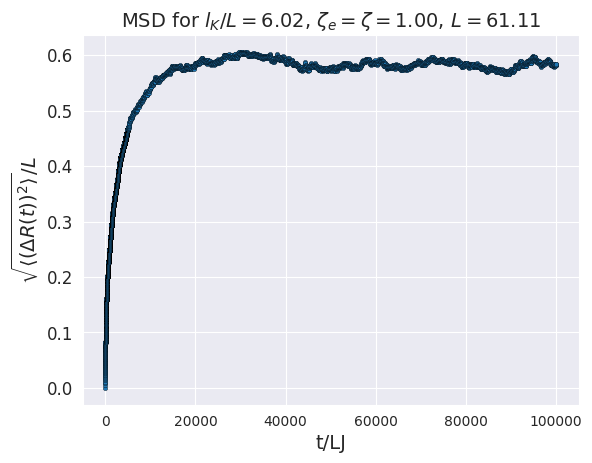

In [59]:
plot_msd.plot_MSD(df_msd_bare_main_ax_frame, log_scale=False, l_K=l_K_bare, L_contour=L_contour, zeta_e=1.0, zeta=1.0)

<Axes: title={'center': 'MSD on log-log scale for $l_K/L=6.02$, $\\zeta_e = \\zeta= 1.00$, $L=61.11$'}, xlabel='t/LJ', ylabel='$ \\sqrt {{\\langle (\\Delta R(t))^2 \\rangle}} / L$'>

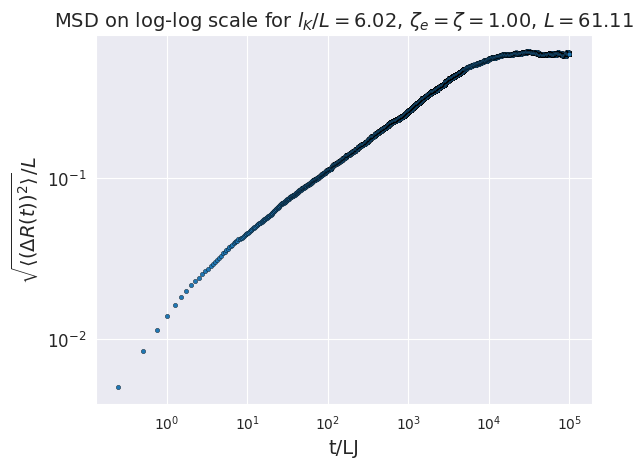

In [60]:
plot_msd.plot_MSD(df_msd_bare_main_ax_frame, log_scale=True, l_K=l_K_bare, L_contour=L_contour, zeta_e=1.0, zeta=1.0)

#### Plot MSD dimensions

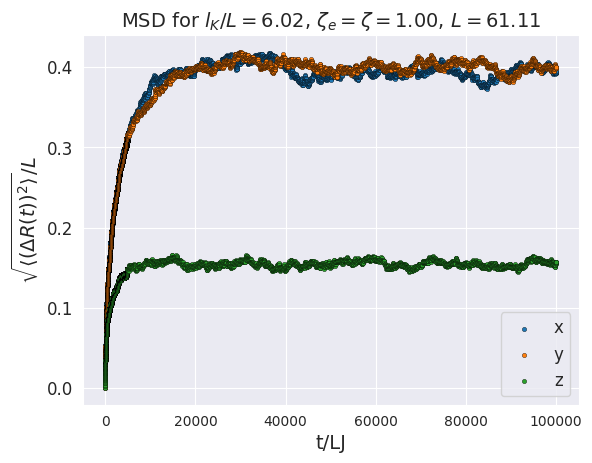

In [61]:
for dim in dims:
    plot_msd.plot_MSD(
        df_msd_bare_main_ax_frame,
        log_scale=False,
        label=dim,
        col=f"dR_{dim}^2",
        l_K=l_K_bare,
        L_contour=L_contour,
        zeta=1.0,
        zeta_e=1.0
    )


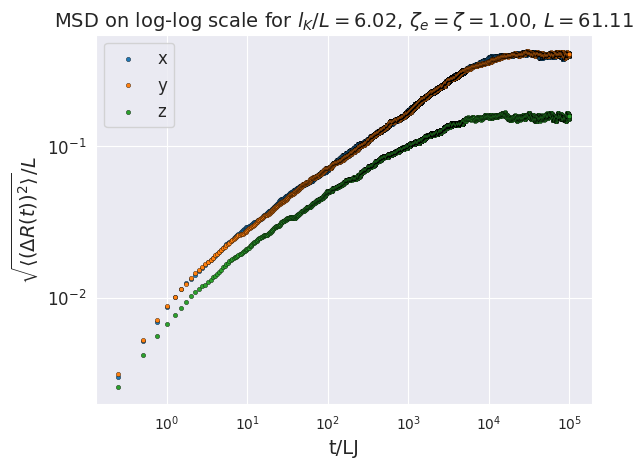

In [62]:
for dim in dims:
    plot_msd.plot_MSD(
        df_msd_bare_main_ax_frame,
        log_scale=True,
        label=dim,
        col=f"dR_{dim}^2",
        l_K=l_K_bare,
        L_contour=L_contour,
        zeta=1.0,
        zeta_e=1.0
    )

## Compare: EEA1+Rab5 vs EEA1

Text(0.3, 0.1, 'EEA1: $l_K/L =  6.02$ \nEEA1+Rab5: $l_K/L = 2.9293 \\pm 0.1035$ \n$\\Delta = -3.09L$')

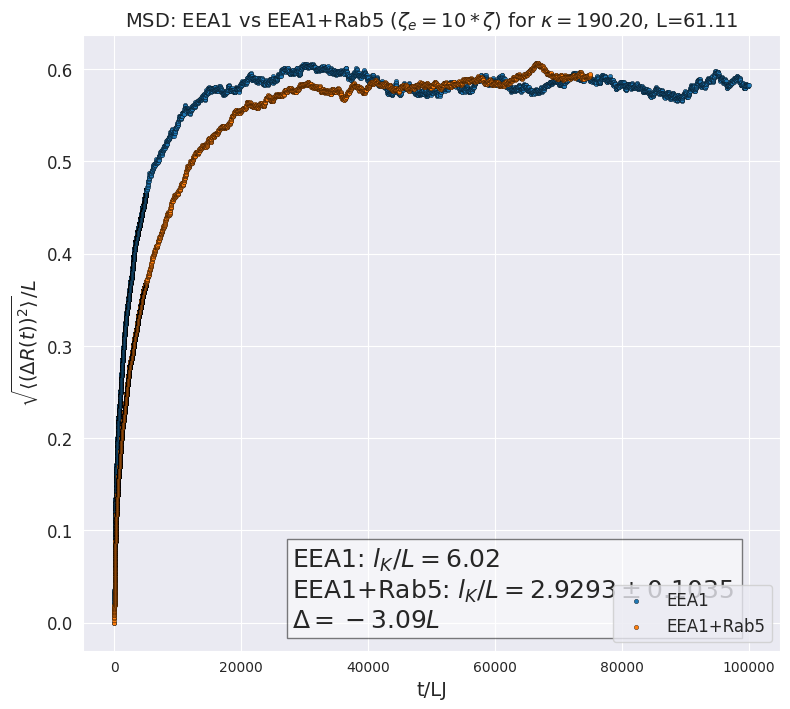

In [63]:
ax: plt.Axes
fig: plt.Figure

fig, ax = plt.subplots(figsize=(9,8))

plot_msd.plot_MSD(
    df_msd_bare_main_ax_frame,
    log_scale=False,
    l_K=l_K_bare,
    L_contour=L_contour,
    zeta_e=1.0,
    zeta=1.0,
    title="",
    ax=ax,
    label="EEA1",
)

plot_msd.plot_MSD(
    df_msd_conn_main_ax_frame,
    log_scale=False,
    l_K=l_K_estimate_conn["l_K"],
    L_contour=L_contour,
    zeta_e=zeta_end_conn,
    zeta=1.0,
    title="",
    ax=ax,
    label="EEA1+Rab5",
)

ax.set(
    title=f"MSD: EEA1 vs EEA1+Rab5 ($\zeta_e = 10*\zeta$) for $\kappa={kappa:.2f}$, L={L_contour:.2f}"
)

ax.text(
    x=.3,
    y=.1,
    s=f"EEA1: $l_K/L = {l_K_bare/L_contour : .2f}$ \n"
      f"EEA1+Rab5: $l_K/L = {l_K_estimate_conn['l_K']/ L_contour :.4f} \pm {l_K_estimate_conn['d_l_K']/ L_contour:.4f}$ \n"
      f"$\Delta = {(l_K_estimate_conn['l_K'] - l_K_bare)/L_contour : .2f}L$",
    horizontalalignment='left',
    verticalalignment='center',
    transform=ax.transAxes,
    fontdict=dict(size=18),
    bbox=dict(edgecolor="black", alpha=0.5, facecolor="white")
)

Text(0.3, 0.1, 'EEA1: $l_K/L =  6.02$ \nEEA1+Rab5: $l_K/L = 2.9293 \\pm 0.1035$ \n$\\Delta = -3.09L$')

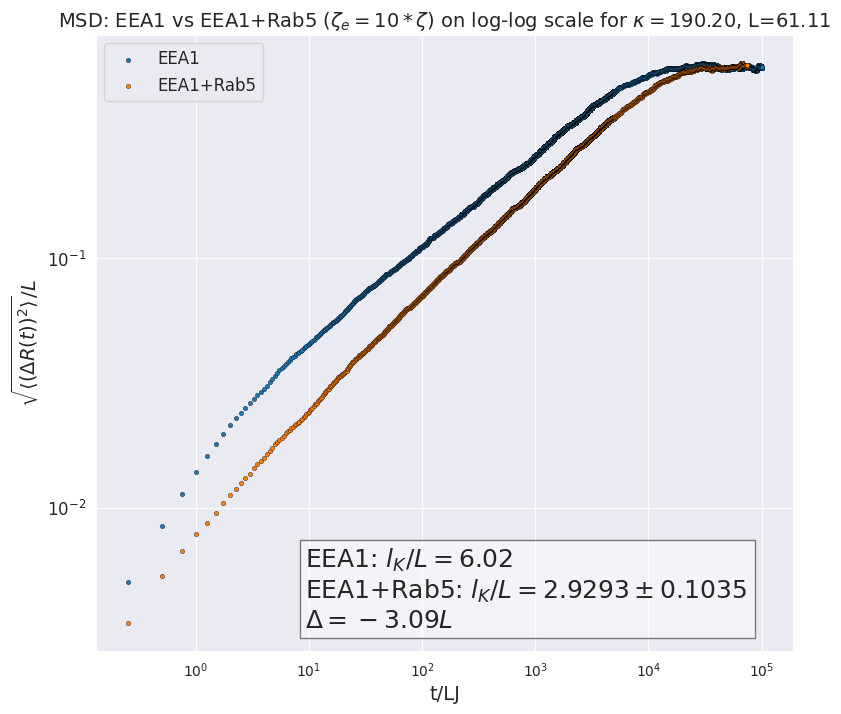

In [64]:
ax: plt.Axes
fig: plt.Figure

fig, ax = plt.subplots(figsize=(9,8))

plot_msd.plot_MSD(
    df_msd_bare_main_ax_frame,
    log_scale=True,
    l_K=l_K_bare,
    L_contour=L_contour,
    zeta_e=1.0,
    zeta=1.0,
    title="",
    ax=ax,
    label="EEA1",
)

plot_msd.plot_MSD(
    df_msd_conn_main_ax_frame,
    log_scale=True,
    l_K=l_K_estimate_conn["l_K"],
    L_contour=L_contour,
    zeta_e=zeta_end_conn,
    zeta=1.0,
    title="",
    ax=ax,
    label="EEA1+Rab5",
)

ax.set(
    title=f"MSD: EEA1 vs EEA1+Rab5 ($\zeta_e = 10*\zeta$) on log-log scale for $\kappa={kappa:.2f}$, L={L_contour:.2f}"
)

ax.text(
    x=.3,
    y=.1,
    s=f"EEA1: $l_K/L = {l_K_bare/L_contour : .2f}$ \n"
      f"EEA1+Rab5: $l_K/L = {l_K_estimate_conn['l_K']/ L_contour :.4f} \pm {l_K_estimate_conn['d_l_K']/ L_contour:.4f}$ \n"
      f"$\Delta = {(l_K_estimate_conn['l_K'] - l_K_bare)/L_contour : .2f}L$",
    horizontalalignment='left',
    verticalalignment='center',
    transform=ax.transAxes,
    fontdict=dict(size=18),
    bbox=dict(edgecolor="black", alpha=0.5, facecolor="white")
)

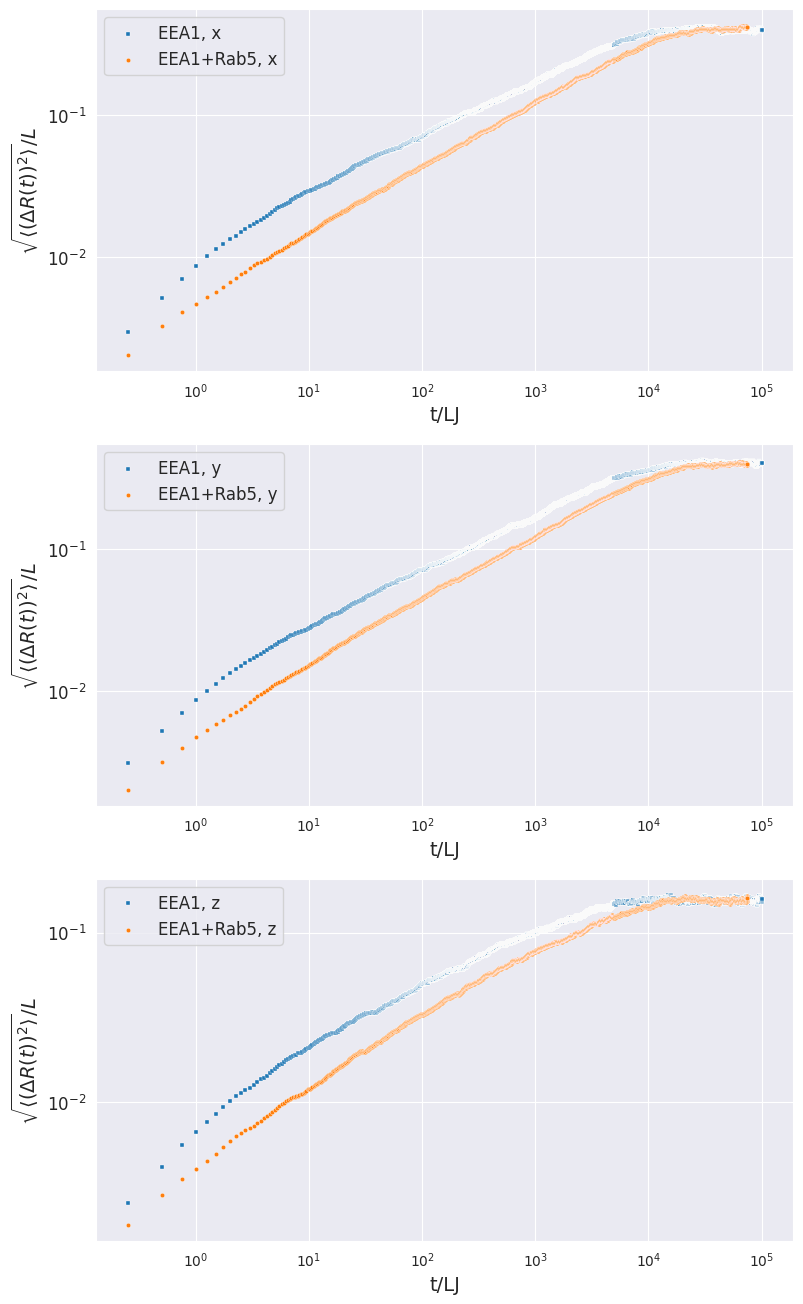

In [65]:
import matplotlib.markers

ax: plt.Axes
fig: plt.Figure

fig, axs = plt.subplots(nrows=3, figsize=(9,16))

colors = ["orange", "green", "blue"]

for dim, ax in zip(dims, axs):

    plot_msd.plot_MSD(
        df_msd_bare_main_ax_frame,
        col=f"dR_{dim}^2",
        log_scale=True,
        l_K=l_K_bare,
        L_contour=L_contour,
        zeta_e=1.0,
        zeta=1.0,
        title="",
        ax=ax,
        label=f"EEA1, {dim}",
        marker=matplotlib.markers.MarkerStyle(marker="s")
    )

    plot_msd.plot_MSD(
        df_msd_conn_main_ax_frame,
        log_scale=True,
        col=f"dR_{dim}^2",
        l_K=l_K_estimate_conn["l_K"],
        L_contour=L_contour,
        zeta_e=zeta_end_conn,
        zeta=1.0,
        title="",
        ax=ax,
        label=f"EEA1+Rab5, {dim}",
        marker=matplotlib.markers.MarkerStyle(marker="o")
    )


